## 0. Load All Data in From CSV Documents

In [1]:
# package imports for clustering
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from ImageIOFunctions import LoadImageFromCSV
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

Training data is retrieved and stored from 6 csv documents, where each CSV document contains the data for an image on different channels (RGB) of the satellite image. These are then grouped to produce the x and y raw data.

In [2]:
filenames = ['1000_1000.csv','1000_2000.csv','1000_3000.csv','1000_4000.csv','1000_5000.csv','1000_6000.csv']

In [3]:
# image data red retrieval from csv
reddatafnames = [os.path.join(os.getcwd(),'data','red'+x) for x in filenames]
reddatalist = [LoadImageFromCSV(fname) for fname in reddatafnames]

# stack data vertically to produce raw image data array
redimage_structured = np.vstack(tuple(reddatalist))
raw_imagered = redimage_structured.flatten()

In [4]:
# image data blue retrieval from csv
bluedatafnames = [os.path.join(os.getcwd(),'data','blue'+x) for x in filenames]
bluedatalist = [LoadImageFromCSV(fname) for fname in bluedatafnames]

# stack data vertically to produce raw image data array
blueimage_structured = np.vstack(tuple(bluedatalist))
raw_imageblue = blueimage_structured.flatten()

In [5]:
# image data green retrieval from csv
greendatafnames = [os.path.join(os.getcwd(),'data','green'+x) for x in filenames]
greendatalist = [LoadImageFromCSV(fname) for fname in greendatafnames]

# stack data vertically to produce raw image data array
greenimage_structured = np.vstack(tuple(greendatalist))
raw_imagegreen = greenimage_structured.flatten()

In [6]:
# image data blue retrieval from csv
nirdatafnames = [os.path.join(os.getcwd(),'data','nir'+x) for x in filenames]
nirdatalist = [LoadImageFromCSV(fname) for fname in nirdatafnames]

# stack data vertically to produce raw image data array
nirimage_structured = np.vstack(tuple(nirdatalist))
raw_imagenir = nirimage_structured.flatten()

In [8]:
# label data retrieval from csv
labeldatafnames = [os.path.join(os.getcwd(),'data','label'+x) for x in filenames]
labeldatalist = [LoadImageFromCSV(fname) for fname in labeldatafnames]

# stack data vertically to produce raw label data array
labels_structured = np.vstack(tuple(labeldatalist))
raw_labels = labels_structured.flatten()

In [9]:
# generate NDVI values
ndviimage_structured = (nirimage_structured - redimage_structured) / (nirimage_structured + redimage_structured + 0.00001)
raw_imagendvi = ndviimage_structured.flatten()

Quick sanity check using imshow to make sure that nothing funky happened with training data or label data

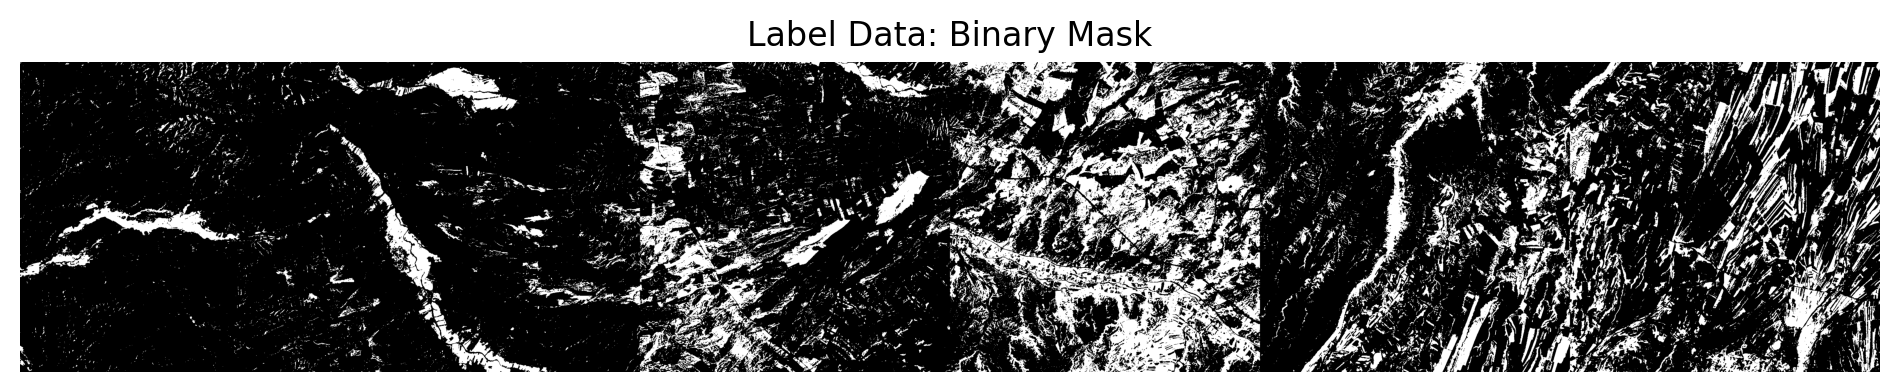

In [10]:
plt.imshow(labels_structured.T, cmap='gray')
plt.title('Label Data: Binary Mask')
plt.axis('off')
plt.show()

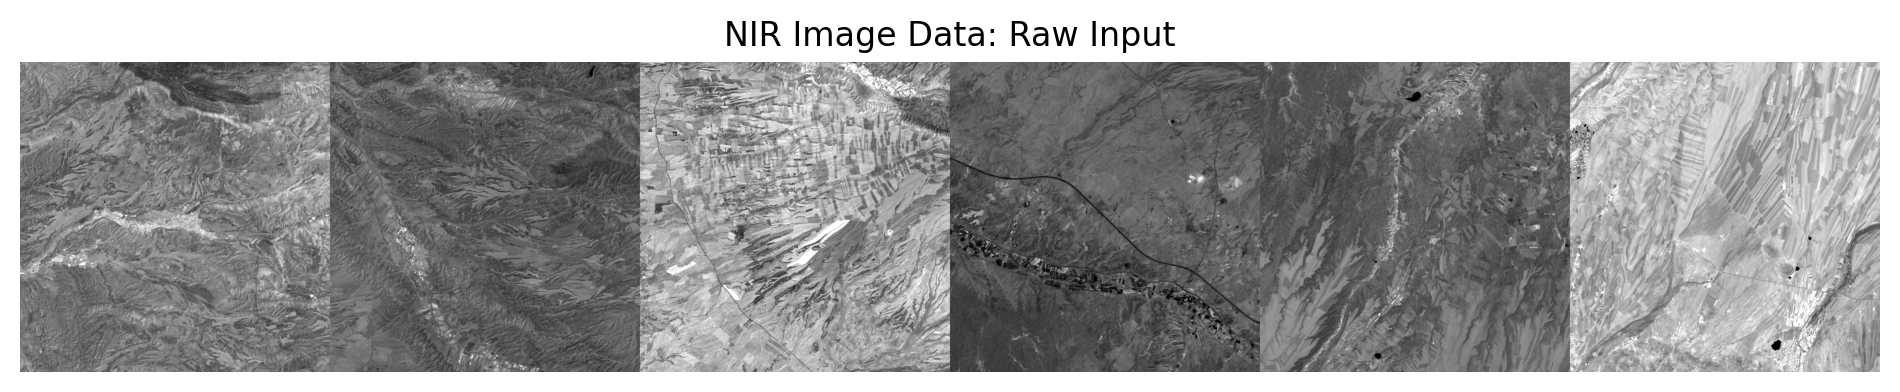

In [11]:
plt.imshow(nirimage_structured.T, cmap='gray')
plt.title('NIR Image Data: Raw Input')
plt.axis('off')
plt.show()

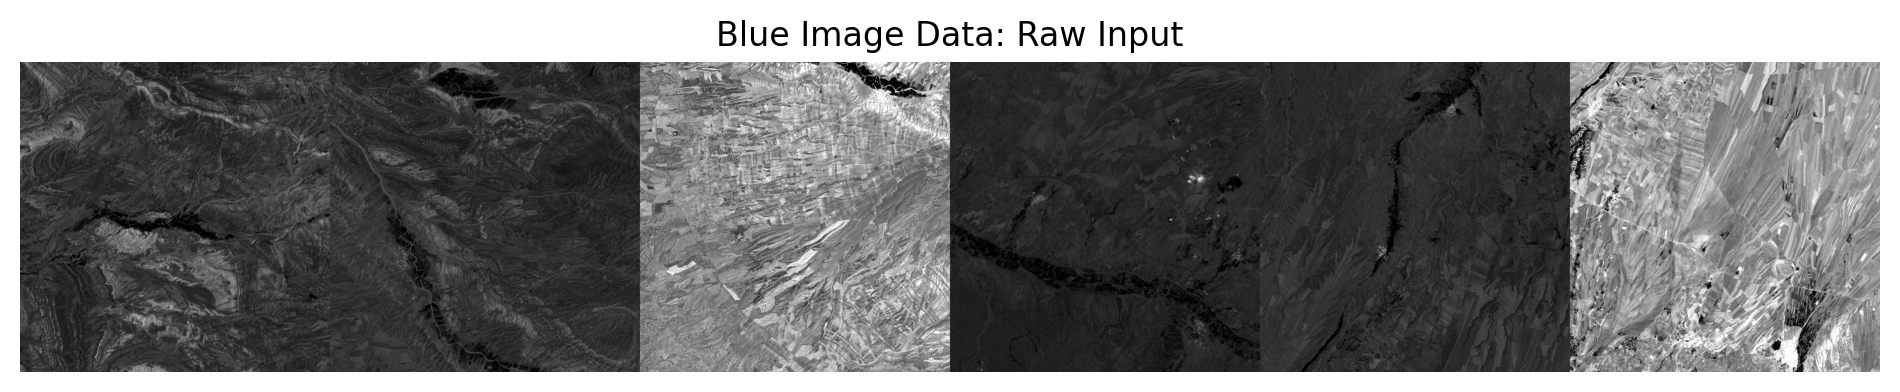

In [12]:
plt.imshow(blueimage_structured.T, cmap='gray')
plt.title('Blue Image Data: Raw Input')
plt.axis('off')
plt.show()

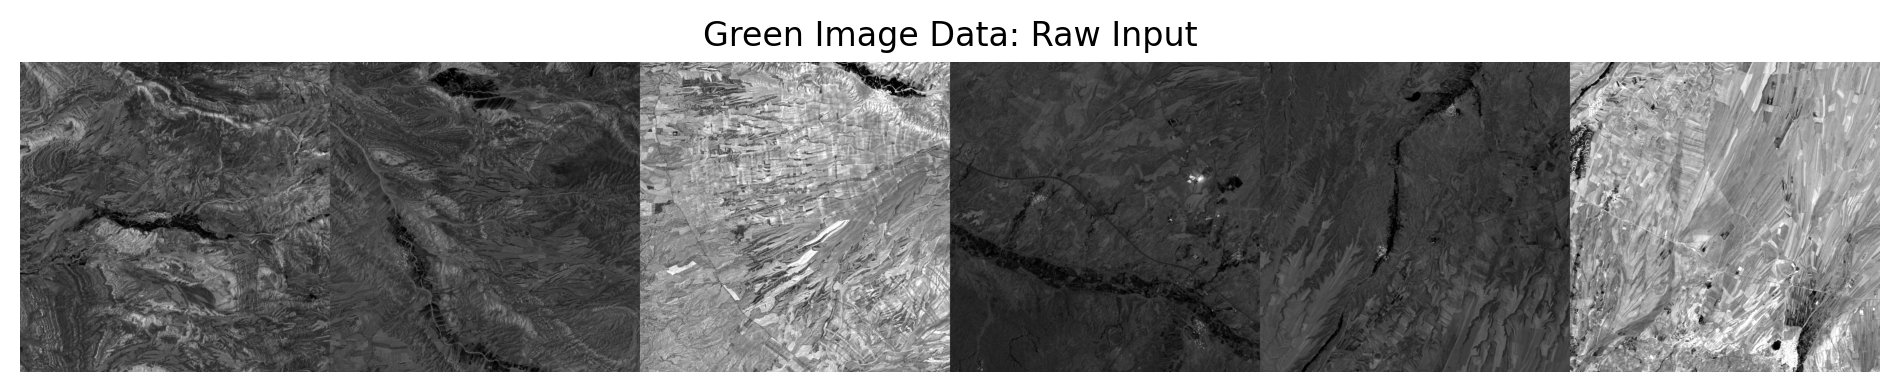

In [13]:
plt.imshow(greenimage_structured.T, cmap='gray')
plt.title('Green Image Data: Raw Input')
plt.axis('off')
plt.show()

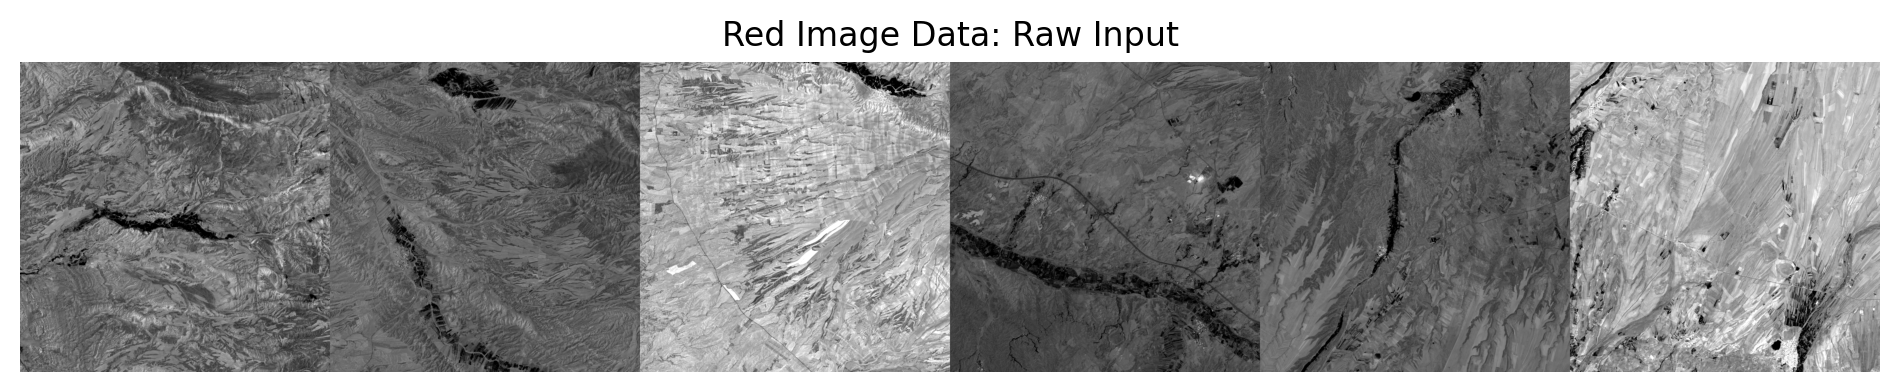

In [14]:
plt.imshow(redimage_structured.T, cmap='gray')
plt.title('Red Image Data: Raw Input')
plt.axis('off')
plt.show()

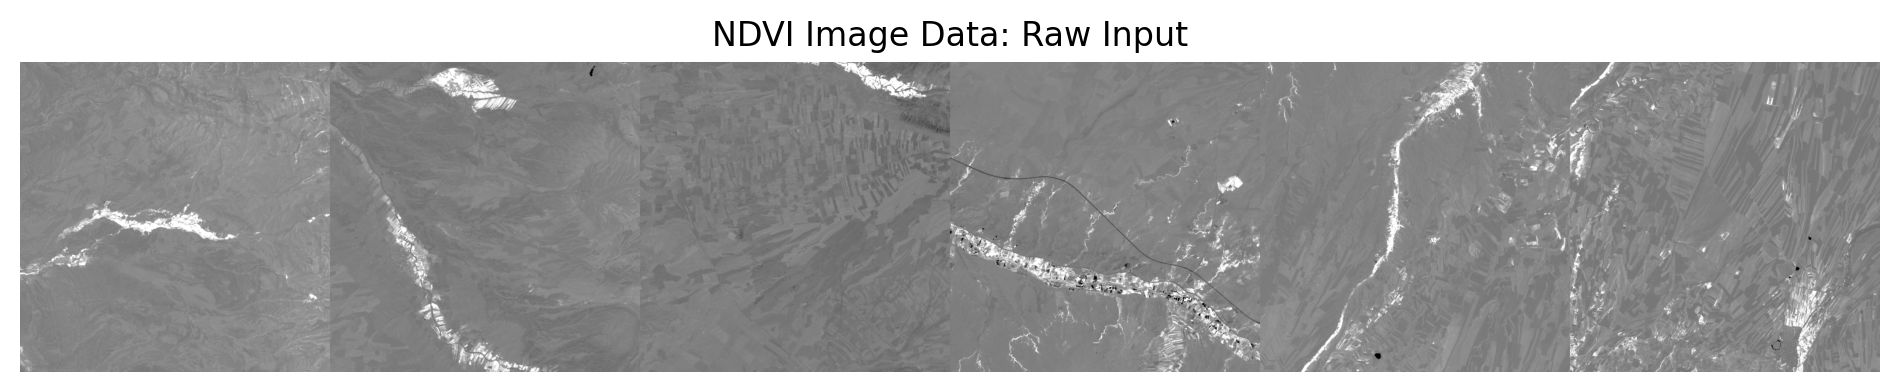

In [15]:
plt.imshow(ndviimage_structured.T, cmap='gray')
plt.title('NDVI Image Data: Raw Input')
plt.axis('off')
plt.show()

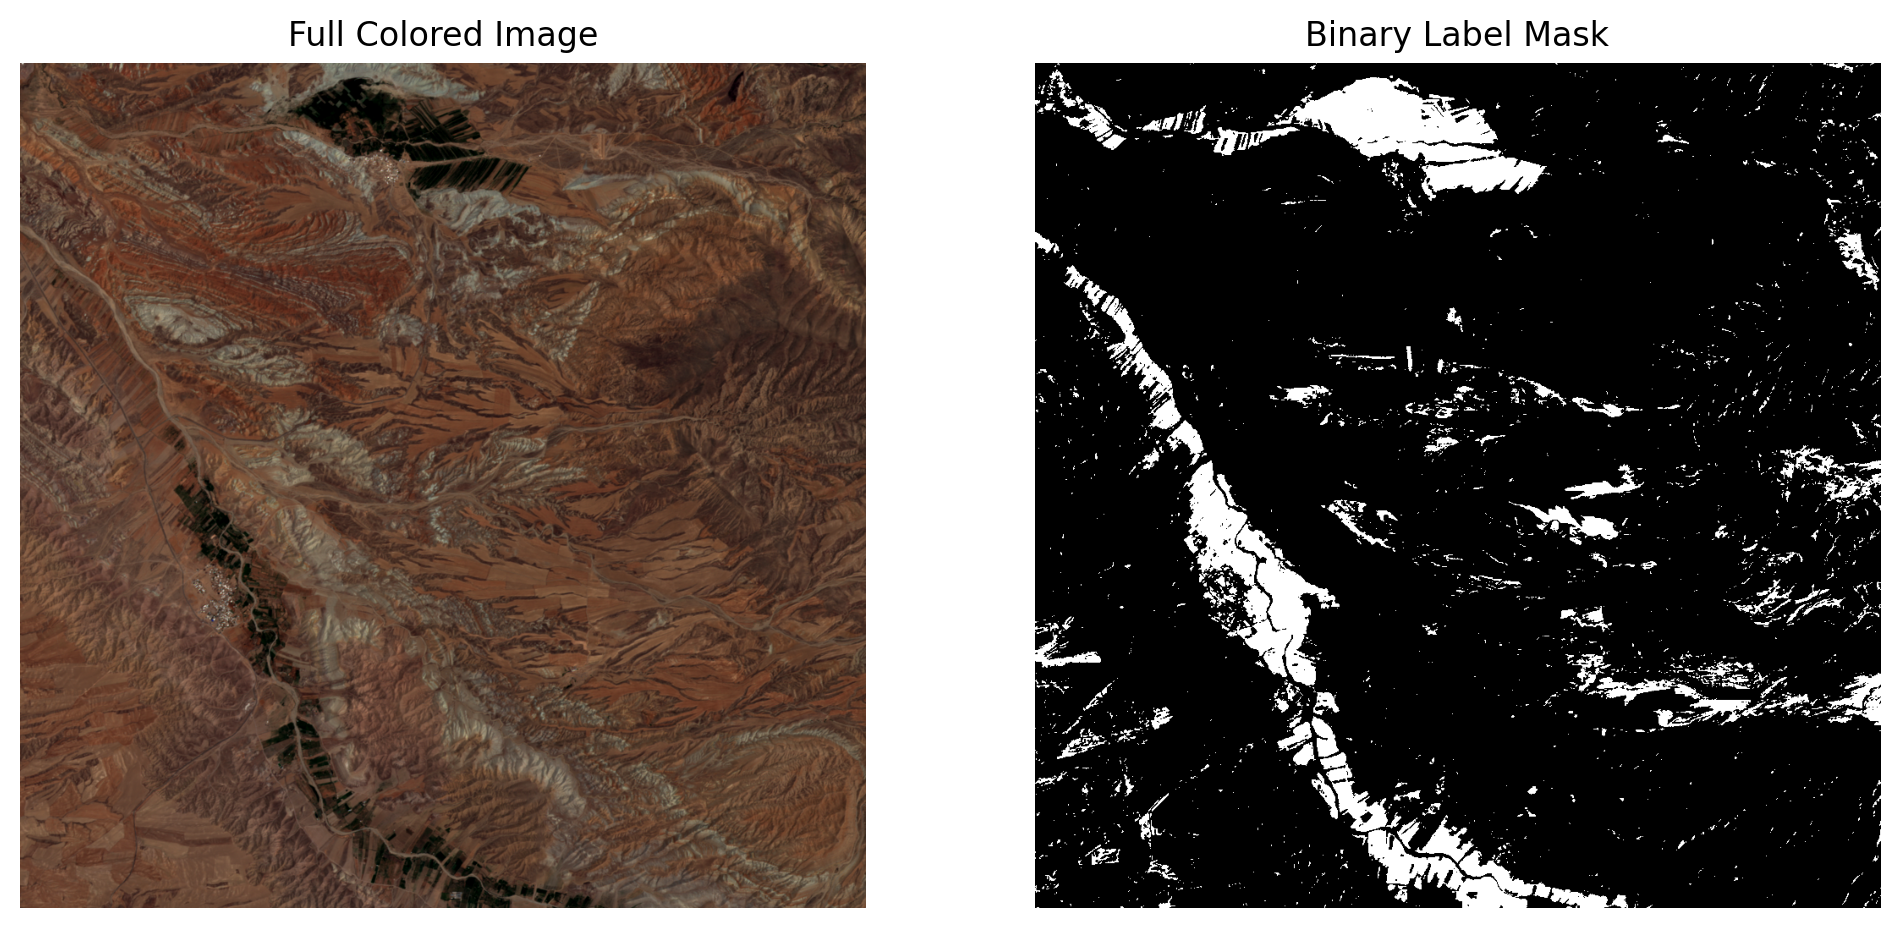

<Figure size 2400x1600 with 0 Axes>

In [16]:
# stack on new axis to form colored image
colored_image = np.stack((redimage_structured.T,greenimage_structured.T,blueimage_structured.T),axis=2)

# two frame subplot
fig, ax = plt.subplots(1, 2, frameon=False)

ax[0].imshow(colored_image[:,1000:2000,:])
ax[0].set_title('Full Colored Image')
ax[0].axis("off")

ax[1].imshow(labels_structured.T[:,1000:2000], cmap='gray')
ax[1].set_title('Binary Label Mask')
ax[1].axis("off")

plt.show()
plt.savefig('demoimagewithlabel.png', transparent=True)

Next, the csv data must be collapsed and converted to record data, with shape (n_samples, n_features), with the label data structured as (n_samples).

In [17]:
# import train test split function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# collapse and collect input channels and store as record array
raw_image = np.vstack((raw_imagered,raw_imagegreen,raw_imageblue,raw_imagenir,raw_imagendvi)).T
raw_image = StandardScaler().fit_transform(raw_image)
# perform train test split
image_train, image_test, label_train, label_test = train_test_split(raw_image, raw_labels, test_size=0.2)

## 0.1 Data Exploration

In [18]:
# remap images to 0-255
image_exp = image_train
for col in range(image_exp.shape[1]):
    image_exp[:,col] = (image_train[:,col] - np.amin(image_train[:,col])) / (np.amax(image_train[:,col]) - np.amin(image_train[:,col]))

# explore distribution of values between positive and negative classes
average_pixels = np.empty((4,2))
average_pixels[0,:] = (np.mean(image_exp[label_train == 1,0]), np.mean(image_exp[label_train == 0,0]))
average_pixels[1,:] = (np.mean(image_exp[label_train == 1,1]), np.mean(image_exp[label_train == 0,1]))
average_pixels[2,:] = (np.mean(image_exp[label_train == 1,2]), np.mean(image_exp[label_train == 0,2]))
average_pixels[3,:] = (np.mean(image_exp[label_train == 1,3]), np.mean(image_exp[label_train == 0,3]))

# print averages across different channels
print(average_pixels)

[[0.38640195 0.47439334]
 [0.2908119  0.38256267]
 [0.24382217 0.33004346]
 [0.52068645 0.48025936]]


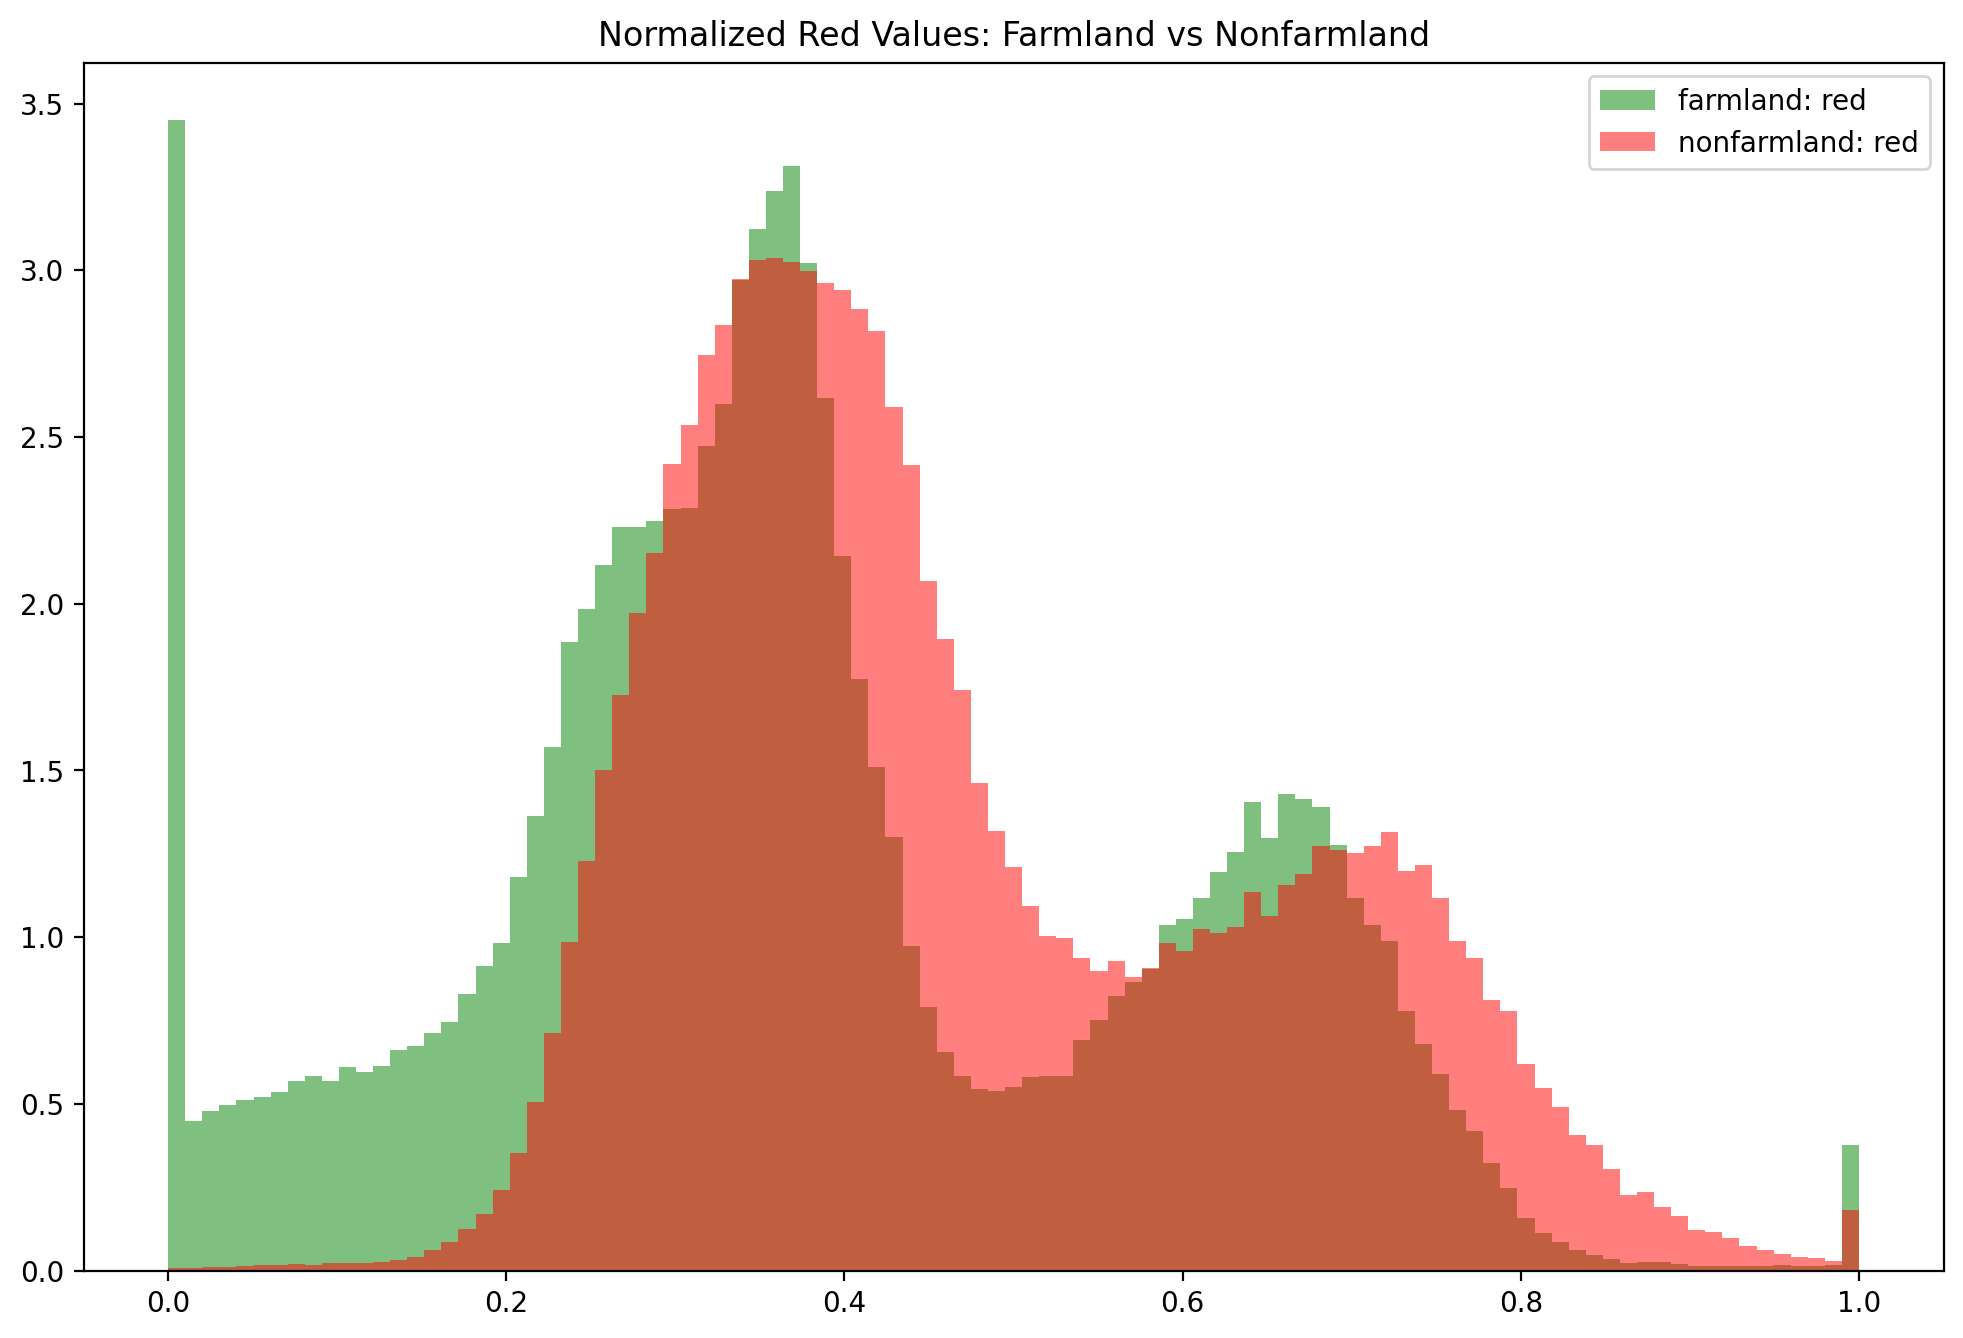

In [19]:
# plot histogram
bins = np.linspace(0, 1, 100)

plt.hist(image_exp[label_train == 1,0], bins, color='g', alpha=0.5, label='farmland: red', density=True)
plt.hist(image_exp[label_train == 0,0], bins, color='r', alpha=0.5, label='nonfarmland: red', density=True)
plt.title('Normalized Red Values: Farmland vs Nonfarmland')
plt.legend(loc='upper right')
plt.show()

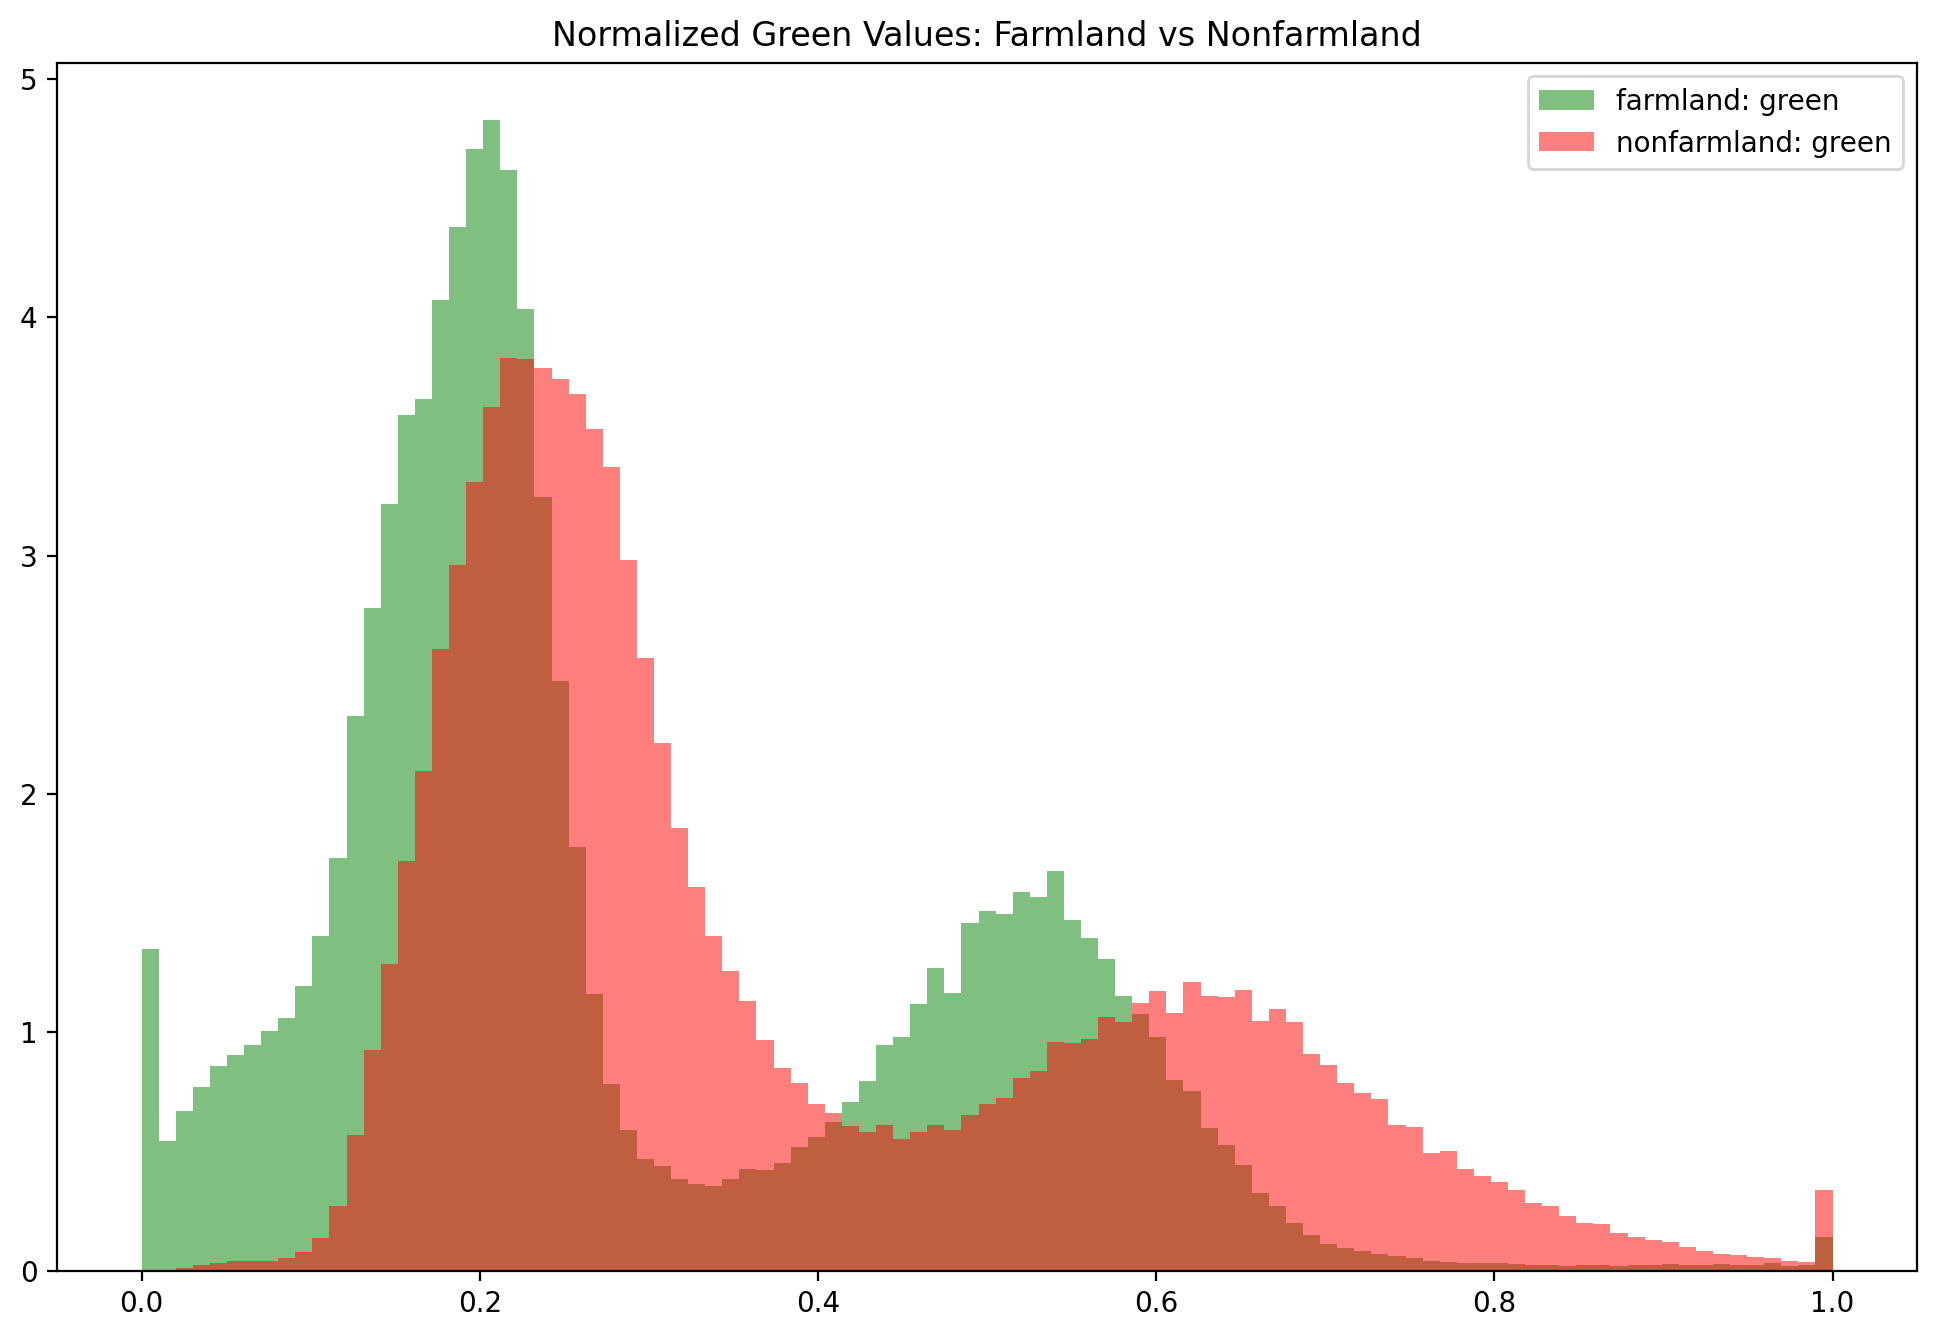

In [20]:
# plot histogram
bins = np.linspace(0, 1, 100)

plt.hist(image_exp[label_train == 1,1], bins, color='g', alpha=0.5, label='farmland: green', density=True)
plt.hist(image_exp[label_train == 0,1], bins, color='r', alpha=0.5, label='nonfarmland: green', density=True)
plt.title('Normalized Green Values: Farmland vs Nonfarmland')
plt.legend(loc='upper right')
plt.show()

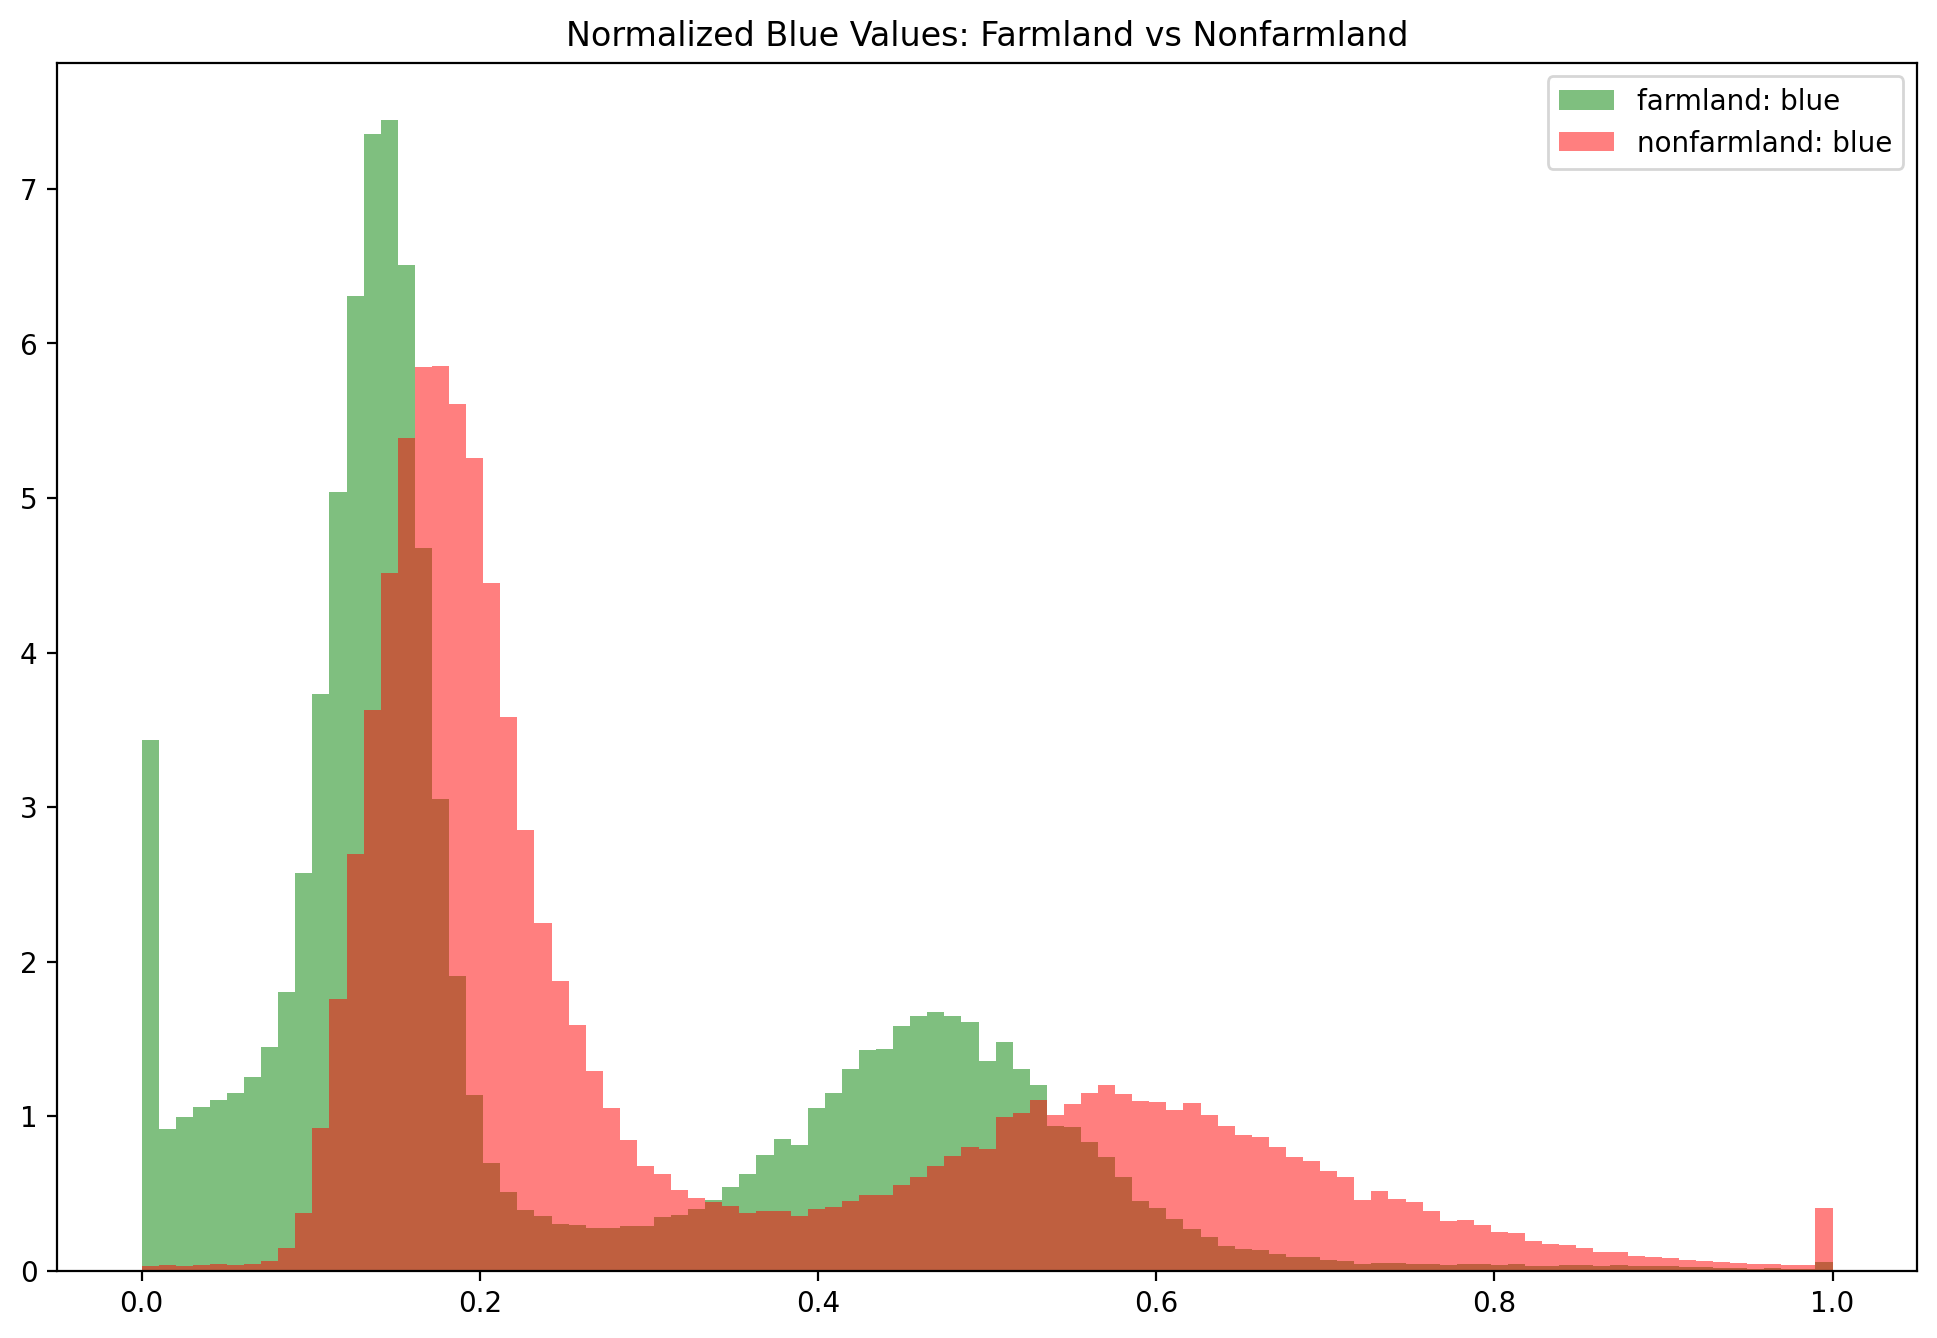

In [21]:
# plot histogram
bins = np.linspace(0, 1, 100)

plt.hist(image_exp[label_train == 1,2], bins, color='g', alpha=0.5, label='farmland: blue', density=True)
plt.hist(image_exp[label_train == 0,2], bins, color='r', alpha=0.5, label='nonfarmland: blue', density=True)
plt.title('Normalized Blue Values: Farmland vs Nonfarmland')
plt.legend(loc='upper right')
plt.show()

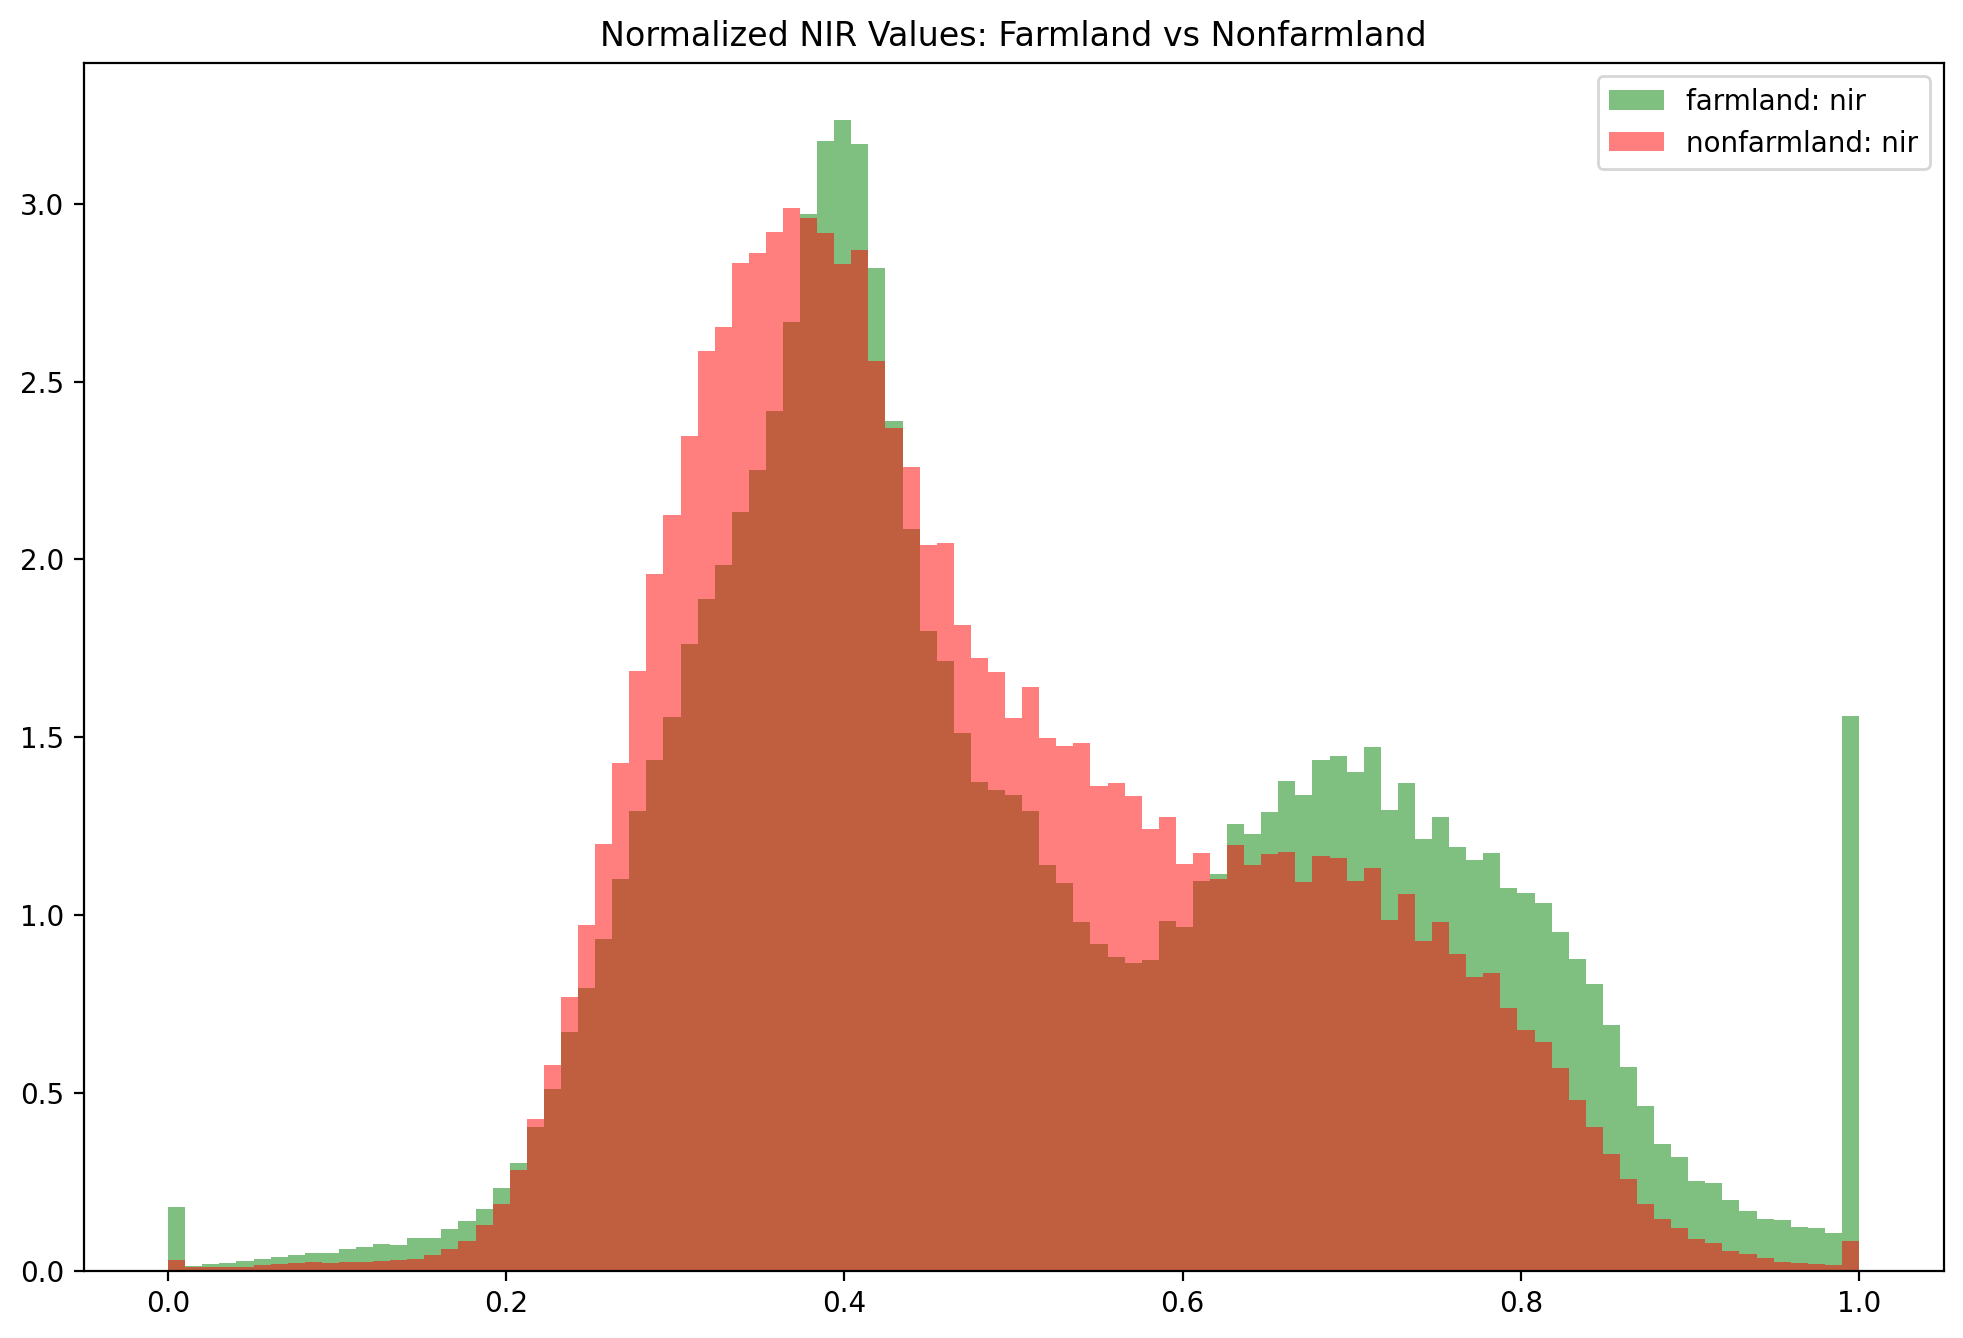

In [22]:
# plot histogram
bins = np.linspace(0, 1, 100)

plt.hist(image_exp[label_train == 1,3], bins, color='g', alpha=0.5, label='farmland: nir', density=True)
plt.hist(image_exp[label_train == 0,3], bins, color='r', alpha=0.5, label='nonfarmland: nir', density=True)
plt.title('Normalized NIR Values: Farmland vs Nonfarmland')
plt.legend(loc='upper right')
plt.show()

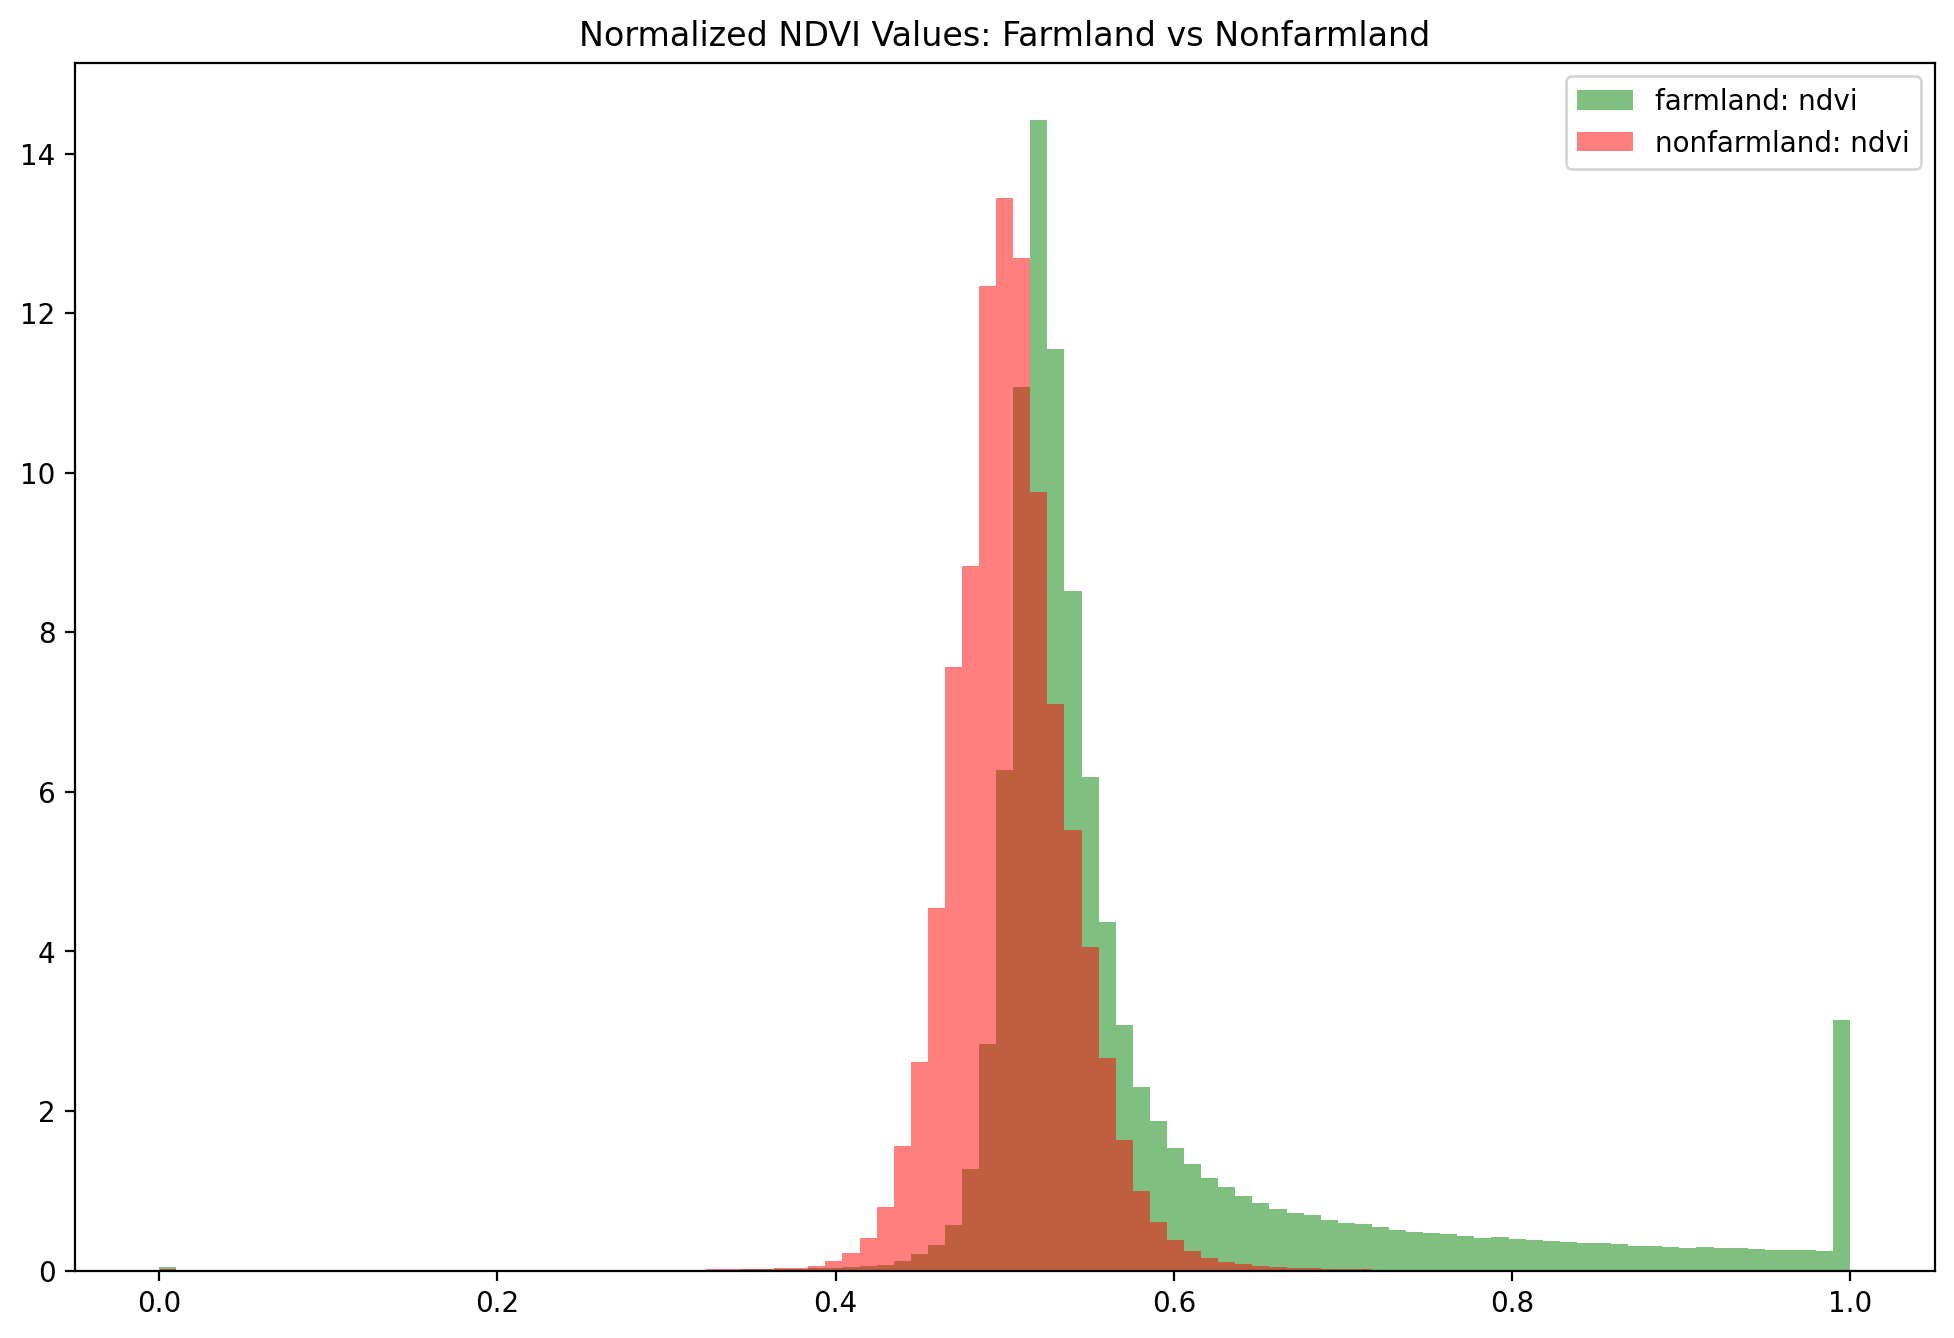

In [23]:
# plot histogram
bins = np.linspace(0, 1, 100)

plt.hist(image_exp[label_train == 1,4], bins, color='g', alpha=0.5, label='farmland: ndvi', density=True)
plt.hist(image_exp[label_train == 0,4], bins, color='r', alpha=0.5, label='nonfarmland: ndvi', density=True)
plt.title('Normalized NDVI Values: Farmland vs Nonfarmland')
plt.legend(loc='upper right')
plt.show()

## 1. Implement Clustering Algorithms

In [24]:
# clustering imports
from sklearn.cluster import MeanShift, MiniBatchKMeans, KMeans

In [32]:
from sklearn.metrics import confusion_matrix
def perf_measure(y_actual, y_hat):
    tn, fp, fn, tp = confusion_matrix(y_actual, y_hat).ravel()
    precision = tp/(tp+fp)
    FPR = fp/(tn+fp)
    TPR = tp/(tp+fn)
    TPR_FPR = TPR/FPR
    accu = (tp+tn)/(tn+ fp+ fn+ tp)
    return(precision, TPR_FPR, TPR)

The k-means algorithm will first be implemented, where the characteristics of each pixel in a channel is used to cluster pixels into two clusters (farmland and nonfarmland)

In [33]:
# generate and fit K-means object on image data
km_cluster = KMeans(n_clusters=2, random_state=5).fit(raw_image)
# store predicted cluster values for K-means
km_predicted = 1 - km_cluster.predict(raw_image)

In [59]:
km_precision, km_TPR_FPR, km_TPR = perf_measure(raw_labels,km_predicted)

In [36]:
knn_TPR

0.2952943366670077

A more robust K-means algorithm will also be used to attempt to cluster image data into two clusters of similar characteristics.

In [37]:
# generate and fit K-means object on image data
mbkm_cluster = MiniBatchKMeans(n_clusters=2, random_state=5).fit(raw_image)
# store predicted cluster values for K-means
mbkm_predicted = 1 - mbkm_cluster.predict(raw_image)

The birch algorithm will also be used for clustering, using a cluster merging procedure.

In [38]:
###
#    OUR DATASET IS TOO BIG, SO THIS DOESN'T WORK
###

# generate and fit K-means object on image data
# spec_cluster = MeanShift().fit(raw_image)
# store predicted cluster values for K-means
# spec_predicted = spec_cluster.predict(raw_image)

## 2. Implement Supervised Algorithms

In [39]:
# model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
# package imports for clustering and modeling performance
from sklearn.metrics import accuracy_score, f1_score

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
# package imports for clustering and modeling performance


In [40]:
# make accuracy dictionary
model_accuracy = {}

First, use decision tree classifier to categorize data.

In [41]:
# generate and fit decision tree classifier
dt = DecisionTreeClassifier(random_state=5).fit(image_train, label_train)
# store decision tree prediction values for validation
dt_predicted = dt.predict(image_test)
dt_accuracy = accuracy_score(label_test,dt_predicted)
dt_f1 = f1_score(label_test,dt_predicted)
dt_precision, dt_TPR_FPR, dt_TPR = perf_measure(label_test, dt_predicted)

Next, a multilayer perceptron network.

In [42]:
# generate and fit decision tree classifier
mlp = MLPClassifier(max_iter=5,random_state=5).fit(image_train, label_train)
# store decision tree prediction values for validation
mlp_predicted = mlp.predict(image_test)
mlp_accuracy = accuracy_score(label_test,mlp_predicted)
mlp_f1 = f1_score(label_test,mlp_predicted)
mlp_precision, mlp_TPR_FPR, mlp_TPR = perf_measure(label_test, mlp_predicted)

C:\Users\rahim035\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Next, Bernoulli Naive Bayes model.

In [45]:
# generate and fit decision tree classifier
bnb = BernoulliNB().fit(image_train, label_train)
# store decision tree prediction values for validation
bnb_predicted = bnb.predict(image_test)
bnb_accuracy = accuracy_score(label_test,bnb_predicted)
bnb_f1 = f1_score(label_test,bnb_predicted)
bnb_precision, bnb_TPR_FPR, bnb_TPR = perf_measure(label_test,bnb_predicted)

Next, Gaussian Naive Bayes model.

In [46]:
# generate and fit decision tree classifier
gnb = GaussianNB().fit(image_train, label_train)
# store decision tree prediction values for validation
gnb_predicted = gnb.predict(image_test)
gnb_accuracy = accuracy_score(label_test,gnb_predicted)
gnb_f1 = f1_score(label_test,gnb_predicted)
gnb_precision, gnb_TPR_FPR, gnb_TPR = perf_measure(label_test,gnb_predicted)

Stochastic Gradient Descent Classifier

In [47]:
# generate and fit decision tree classifier
sgdc = SGDClassifier().fit(image_train, label_train)
# store decision tree prediction values for validation
sgdc_predicted = sgdc.predict(image_test)
sgdc_accuracy = accuracy_score(label_test,sgdc_predicted)
sgdc_f1 = f1_score(label_test,sgdc_predicted)
sgdc_precision, sgdc_TPR_FPR, sgdc_TPR = perf_measure(label_test,sgdc_predicted)

Ridge classifier

In [48]:
# generate and fit decision tree classifier
ridgec = RidgeClassifier().fit(image_train, label_train)
# store decision tree prediction values for validation
ridgec_predicted = ridgec.predict(image_test)
ridgec_accuracy = accuracy_score(label_test,ridgec_predicted)
ridgec_f1 = f1_score(label_test,ridgec_predicted)
ridgec_precision, ridgec_TPR_FPR, ridgec_TPR = perf_measure(label_test,ridgec_predicted)

Random forest classifier

In [49]:
# generate and fit decision tree classifier
rfc = RandomForestClassifier().fit(image_train, label_train)
# store decision tree prediction values for validation
rfc_predicted = rfc.predict(image_test)
rfc_accuracy = accuracy_score(label_test,rfc_predicted)
rfc_f1 = f1_score(label_test,rfc_predicted)
rfc_precision, rfc_TPR_FPR, rfc_TPR = perf_measure(label_test,rfc_predicted)

Adaboost classifier

In [50]:
# generate and fit decision tree classifier
abc = AdaBoostClassifier().fit(image_train, label_train)
# store decision tree prediction values for validation
abc_predicted = abc.predict(image_test)
abc_accuracy = accuracy_score(label_test,abc_predicted)
abc_f1 = f1_score(label_test,abc_predicted)
abc_precision, abc_TPR_FPR, abc_TPR = perf_measure(label_test,abc_predicted)

Gradient boosting classifier

In [51]:
# generate and fit decision tree classifier
gbc = GradientBoostingClassifier().fit(image_train, label_train)
# store decision tree prediction values for validation
gbc_predicted = gbc.predict(image_test)
gbc_accuracy = accuracy_score(label_test,gbc_predicted)
gbc_f1 = f1_score(label_test,gbc_predicted)
gbc_precision, gbc_TPR_FPR, gbc_TPR = perf_measure(label_test,gbc_predicted)

Voting classifier

In [64]:
# generate and fit decision tree classifier
vc = VotingClassifier(estimators=[('dt',dt),('mlp',mlp),('bnb',bnb),('rfc',rfc)], voting='soft').fit(image_train, label_train)
# store decision tree prediction values for validation
vc_predicted = vc.predict(image_test)
vc_accuracy = accuracy_score(label_test,vc_predicted)
vc_f1 = f1_score(label_test,vc_predicted)
vc_precision, vc_TPR_FPR, vc_TPR = perf_measure(label_test,vc_predicted)

C:\Users\rahim035\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


KeyboardInterrupt: 

Linear SVM

In [ ]:
# generate and fit decision tree classifier
svm = LinearSVC().fit(image_train, label_train)
# store decision tree prediction values for validation
svm_predicted = svm.predict(image_test)
svm_accuracy = accuracy_score(label_test,svm_predicted)
svm_f1 = f1_score(label_test,svm_predicted)
svm_precision, svm_TPR_FPR, svm_TPR = perf_measure(label_test,svm_predicted)

KNearestNeighbors

In [ ]:
# generate and fit decision tree classifier
knn = KNeighborsClassifier(n_neighbors=5).fit(image_train, label_train)
# store decision tree prediction values for validation
knn_predicted = knn.predict(image_test)
knn_accuracy = accuracy_score(label_test,knn_predicted)
knn_f1 = f1_score(label_test,knn_predicted)
knn_precision, knn_TPR_FPR, knn_TPR = perf_measure(label_test,knn_predicted)

## 3. Assess performance of All Algorithms

In [53]:
# package imports for clustering and modeling performance
from sklearn.metrics import accuracy_score, f1_score

In [54]:
baseline_accuracy = accuracy_score(raw_labels, np.zeros_like(raw_labels))

In [55]:
print('K-means accuracy:\t\t',accuracy_score(raw_labels,km_predicted))
print('Minibatch K-means accuracy:\t',accuracy_score(raw_labels,mbkm_predicted))


K-means accuracy:		 0.5921768333333334
Minibatch K-means accuracy:	 0.4077056666666667


In [65]:
print('Baseline model accuracy:\t',baseline_accuracy)
print('Decision tree accuracy:\t\t',dt_accuracy)
print('Multilayer perceptron accuracy:\t',mlp_accuracy)
print('Bernoulli NB accuracy:\t\t',bnb_accuracy)
print('Gaussian NB accuracy:\t\t',gnb_accuracy)
print('SGD classifier accuracy:\t',sgdc_accuracy)
print('Ridge classifier accuracy:\t',ridgec_accuracy)
print('Random forest accuracy:\t\t',rfc_accuracy)
print('AdaBoost accuracy:\t\t',abc_accuracy)
print('Gradient boost accuracy:\t',gbc_accuracy)
#print('Voting classifier accuracy:\t',vc_accuracy)
#print('SVM classifier accuracy:\t',svm_accuracy)
#print('KNN classifier accuracy:\t',knn_accuracy)
modellabels = np.array(['Decision Tree','Multilayer Perceptron','Bernoulli NB','Gaussian NB','SGD Classifier','Ridge Classifier','Random Forest','AdaBoost','Gradient Boost'])
modelaccuracies = np.array([dt_accuracy, mlp_accuracy, bnb_accuracy, gnb_accuracy, sgdc_accuracy, ridgec_accuracy, rfc_accuracy, abc_accuracy, gbc_accuracy])

Baseline model accuracy:	 0.8012536666666666
Decision tree accuracy:		 0.6205891666666666
Multilayer perceptron accuracy:	 0.2548816666666667
Bernoulli NB accuracy:		 0.2171475
Gaussian NB accuracy:		 0.2050125
SGD classifier accuracy:	 0.83509
Ridge classifier accuracy:	 0.843325
Random forest accuracy:		 0.47031333333333336
AdaBoost accuracy:		 0.8025283333333333
Gradient boost accuracy:	 0.7596366666666666


In [66]:
print('Decision tree f1:\t\t',dt_f1)
print('Multilayer perceptron f1:\t',mlp_f1)
print('Bernoulli NB f1:\t\t',bnb_f1)
print('Gaussian NB f1:\t\t\t',gnb_f1)
print('SGD classifier f1:\t\t',sgdc_f1)
print('Ridge classifier f1:\t\t',ridgec_f1)
print('Random forest f1:\t\t',rfc_f1)
print('AdaBoost f1:\t\t\t',abc_f1)
print('Gradient boost f1:\t\t',gbc_f1)
#print('Voting classifier f1:\t\t',vc_f1)
#print('SVM classifier f1:\t\t',svm_f1)
#print('KNN classifier f1:\t\t',knn_f1)
modelf1 = np.array([dt_f1, mlp_f1, bnb_f1, gnb_f1, sgdc_f1, ridgec_f1, rfc_f1, abc_f1, gbc_f1])

Decision tree f1:		 0.35299116513118717
Multilayer perceptron f1:	 0.34152491571531884
Bernoulli NB f1:		 0.29886428348057525
Gaussian NB f1:			 0.328979603894793
SGD classifier f1:		 0.4455439996413682
Ridge classifier f1:		 0.5008946253457713
Random forest f1:		 0.3573245651285909
AdaBoost f1:			 0.41677660077183587
Gradient boost f1:		 0.5147589743244653


In [67]:
print('Decision tree precision:\t\t',dt_precision)
print('Multilayer perceptron precision:\t',mlp_precision)
print('Bernoulli NB precision:\t\t',bnb_precision)
print('Gaussian NB precision:\t\t\t',gnb_precision)
print('SGD classifier precision:\t\t',sgdc_precision)
print('Ridge classifier precision:\t\t',ridgec_precision)
print('Random forest precision:\t\t',rfc_precision)
print('AdaBoost precision:\t\t\t',abc_precision)
print('Gradient boost precision:\t\t',gbc_precision)
#print('Voting classifier precision:\t\t',vc_precision)
#print('SVM classifier f1:\t\t',svm_precision)
#print('KNN precision:\t\t',knn_precision)
print('K-means precision:\t\t',km_precision)


Decision tree precision:		 0.26666122743434273
Multilayer perceptron precision:	 0.20704113803962818
Bernoulli NB precision:		 0.18169888612805626
Gaussian NB precision:			 0.19755253616454743
SGD classifier precision:		 0.6682916579113259
Ridge classifier precision:		 0.6799080406754254
Random forest precision:		 0.23526044114494782
AdaBoost precision:			 0.5028835816995016
Gradient boost precision:		 0.42917013809992677
K-means precision:		 0.1797761298804069


In [68]:
print('Decision tree TPR/FPR:\t\t',dt_TPR_FPR)
print('Multilayer perceptron TPR/FPR:\t',mlp_TPR_FPR)
print('Bernoulli NB TPR/FPR:\t\t',bnb_TPR_FPR)
print('Gaussian NB TPR/FPR:\t\t\t',gnb_TPR_FPR)
print('SGD classifier TPR/FPR:\t\t',sgdc_TPR_FPR)
print('Ridge classifier TPR/FPR:\t\t',ridgec_TPR_FPR)
print('Random forest TPR/FPR:\t\t',rfc_TPR_FPR)
print('AdaBoost TPR/FPR:\t\t\t',abc_TPR_FPR)
print('Gradient boost TPR/FPR:\t\t',gbc_TPR_FPR)
#print('Voting classifier TPR/FPR:\t\t',vc_TPR_FPR)
#print('SVM classifier f1:\t\t',svm_TPR_FPR)
#print('kNN TPR/FPR:\t\t',knn_TPR_FPR)
print('K-means TPR/FPR:\t\t',km_TPR_FPR)

Decision tree TPR/FPR:		 1.4702688544090696
Multilayer perceptron TPR/FPR:	 1.0557170122313237
Bernoulli NB TPR/FPR:		 0.8978021756781955
Gaussian NB TPR/FPR:			 0.9954226799745447
SGD classifier TPR/FPR:		 8.14612701232558
Ridge classifier TPR/FPR:		 8.588492550068397
Random forest TPR/FPR:		 1.2438754081568708
AdaBoost TPR/FPR:			 4.090259678099186
Gradient boost TPR/FPR:		 3.0399353138269065
K-means TPR/FPR:		 0.8836301539979611


In [69]:
print('Decision tree recall:\t\t',dt_TPR)
print('Multilayer perceptron recall:\t',mlp_TPR)
print('Bernoulli NB recall:\t\t',bnb_TPR)
print('Gaussian NB recall:\t\t\t',gnb_TPR)
print('SGD classifier recall:\t\t',sgdc_TPR)
print('Ridge classifier recall:\t\t',ridgec_TPR)
print('Random forest recall:\t\t',rfc_TPR)
print('AdaBoost recall:\t\t\t',abc_TPR)
print('Gradient boost recall:\t\t',gbc_TPR)
#print('Voting classifier recall:\t\t',vc_TPR)
#print('SVM classifier recall:\t\t',svm_TPR)
#print('KNNs recall:\t\t',knn_TPR)
print('K-means recall:\t\t',km_TPR)

Decision tree recall:		 0.5219785069156961
Multilayer perceptron recall:	 0.9745352761445256
Bernoulli NB recall:		 0.841474844181443
Gaussian NB recall:			 0.9828399954609833
SGD classifier recall:		 0.33416408545119086
Ridge classifier recall:		 0.39649991384273986
Random forest recall:		 0.742641959846514
AdaBoost recall:			 0.3558462954479547
Gradient boost recall:		 0.6429895308421977
K-means recall:		 0.2952943366670077


In [70]:
print(modellabels)
print(modelaccuracies)
print(modelf1)

['Decision Tree' 'Multilayer Perceptron' 'Bernoulli NB' 'Gaussian NB'
 'SGD Classifier' 'Ridge Classifier' 'Random Forest' 'AdaBoost'
 'Gradient Boost']
[0.62058917 0.25488167 0.2171475  0.2050125  0.83509    0.843325
 0.47031333 0.80252833 0.75963667]
[0.35299117 0.34152492 0.29886428 0.3289796  0.445544   0.50089463
 0.35732457 0.4167766  0.51475897]


In [103]:
for idx, label in enumerate(modellabels):
    print(label,f'accuracy: {modelaccuracies[idx]}',f'f1: {modelf1[idx]}')

Decision Tree accuracy: 0.8453091666666667 f1: 0.6153300992401056
Multilayer Perceptron accuracy: 0.8856491666666667 f1: 0.6787649795045029
Bernoulli NB accuracy: 0.8008141666666667 f1: 0.0
Gaussian NB accuracy: 0.832965 f1: 0.3948299599053186
SGD Classifier accuracy: 0.8405866666666667 f1: 0.35182022715567485
Ridge Classifier accuracy: 0.8389858333333333 f1: 0.33825941921276237
Random Forest accuracy: 0.8884241666666667 f1: 0.6927759637822991
AdaBoost accuracy: 0.8598908333333334 f1: 0.54665908092032
Gradient Boost accuracy: 0.8747916666666666 f1: 0.6295045100582436
Voting Ensemble accuracy: 0.8689441666666666 f1: 0.5750126333937755
SVM accuracy: 0.8505658333333334 f1: 0.46332448456153685
Knearest Neighbors accuracy: 0.8765233333333333 f1: 0.6673849994163547


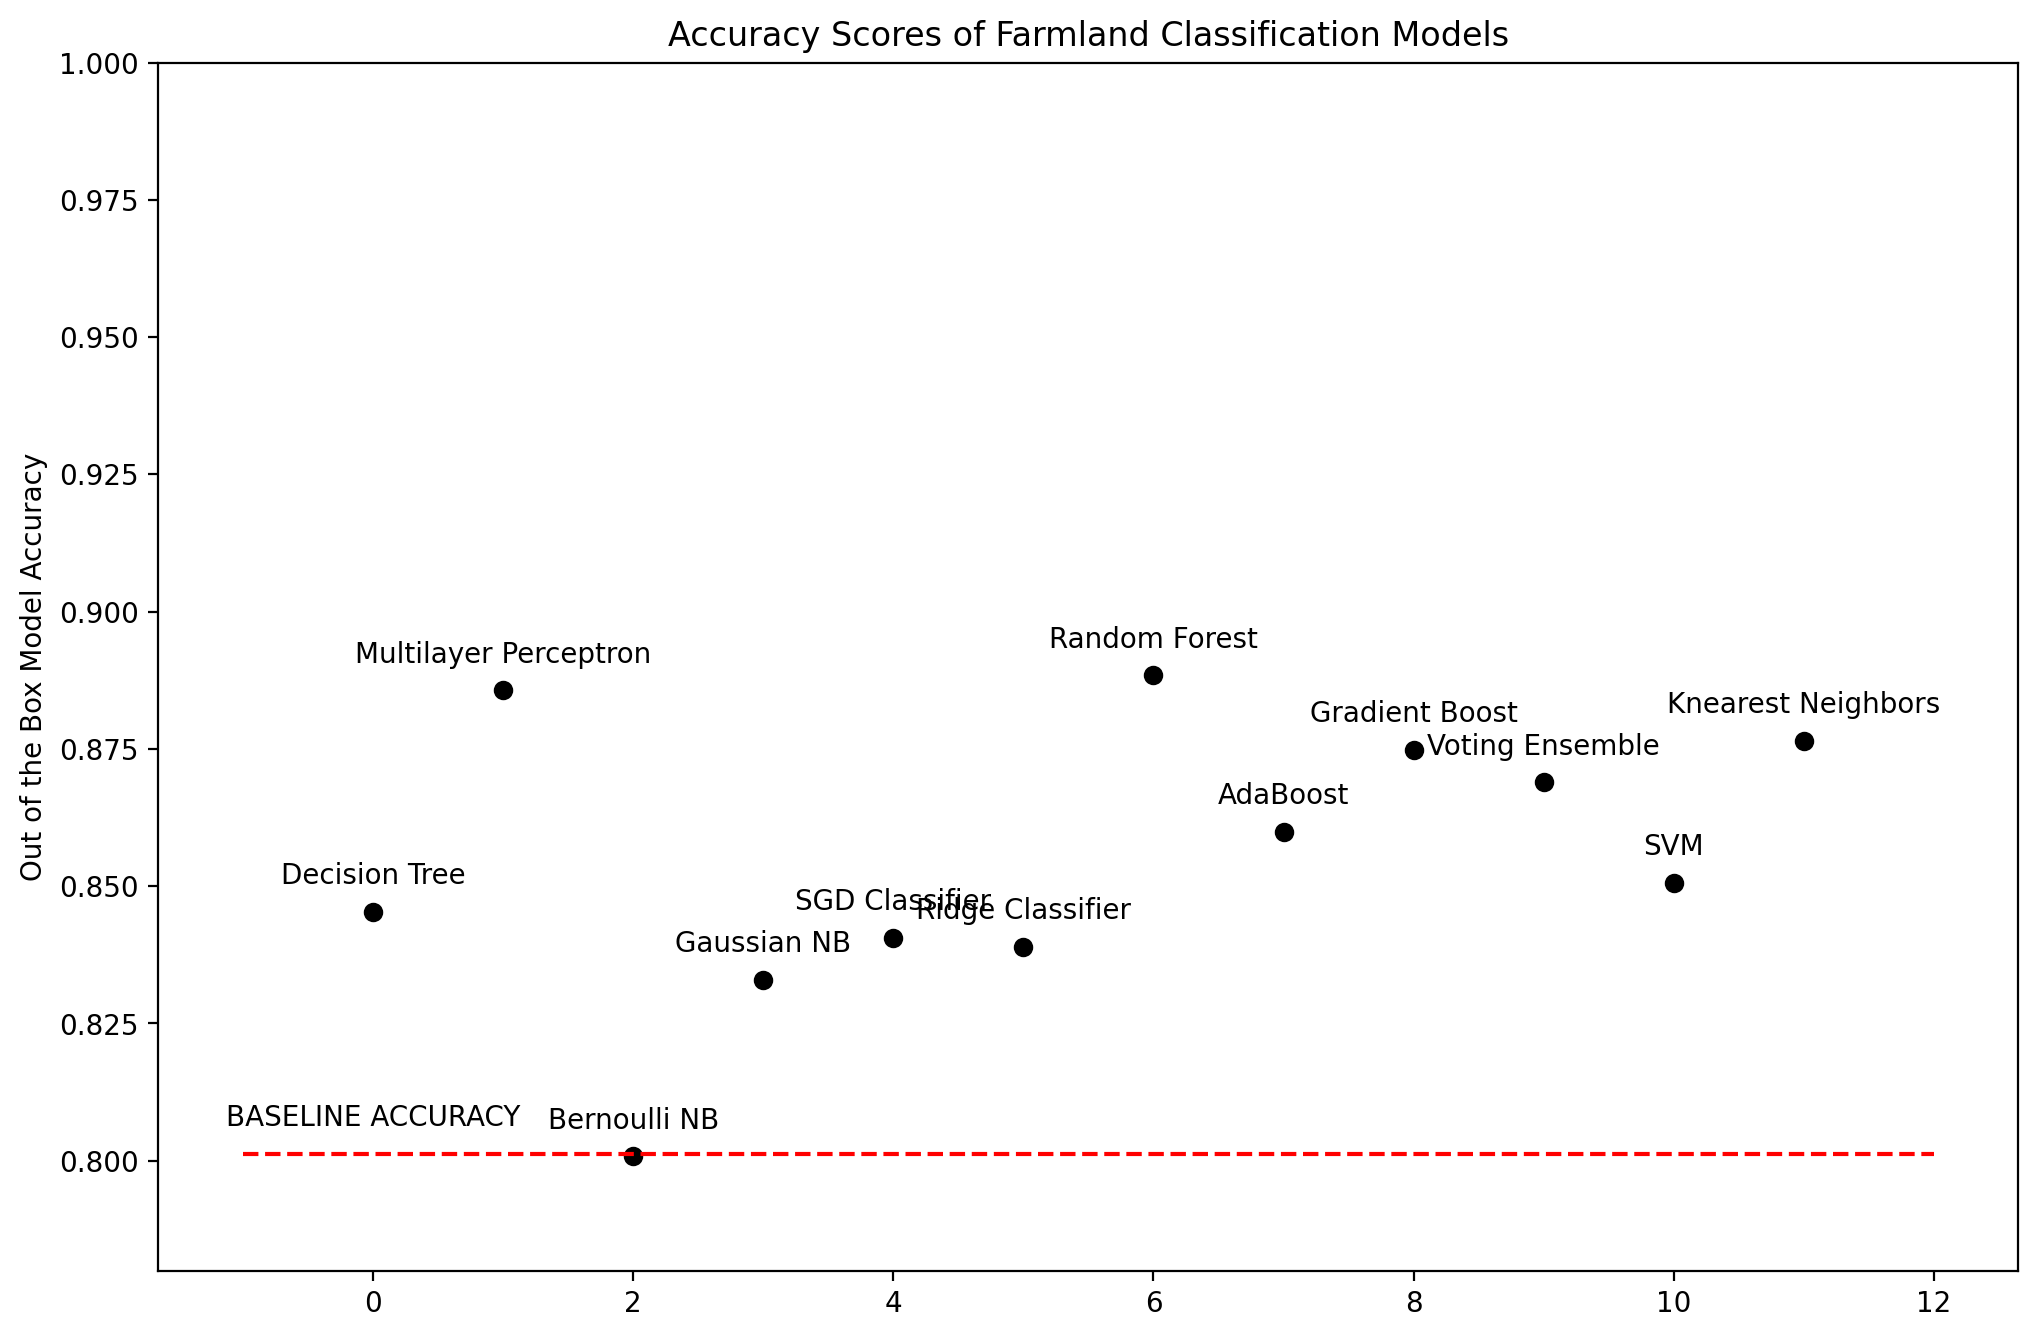

In [107]:
plt.plot(modelaccuracies, 'ko')
plt.ylabel('Out of the Box Model Accuracy')
plt.title('Accuracy Scores of Farmland Classification Models')
plt.ylim(0.78,1)

plt.plot([-1,12],2*[baseline_accuracy],'r--')
plt.annotate('BASELINE ACCURACY',
            (0,baseline_accuracy),
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center')

for idx, label in enumerate(modellabels):
    plt.annotate(label, # this is the text
                 (idx,modelaccuracies[idx]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.show()

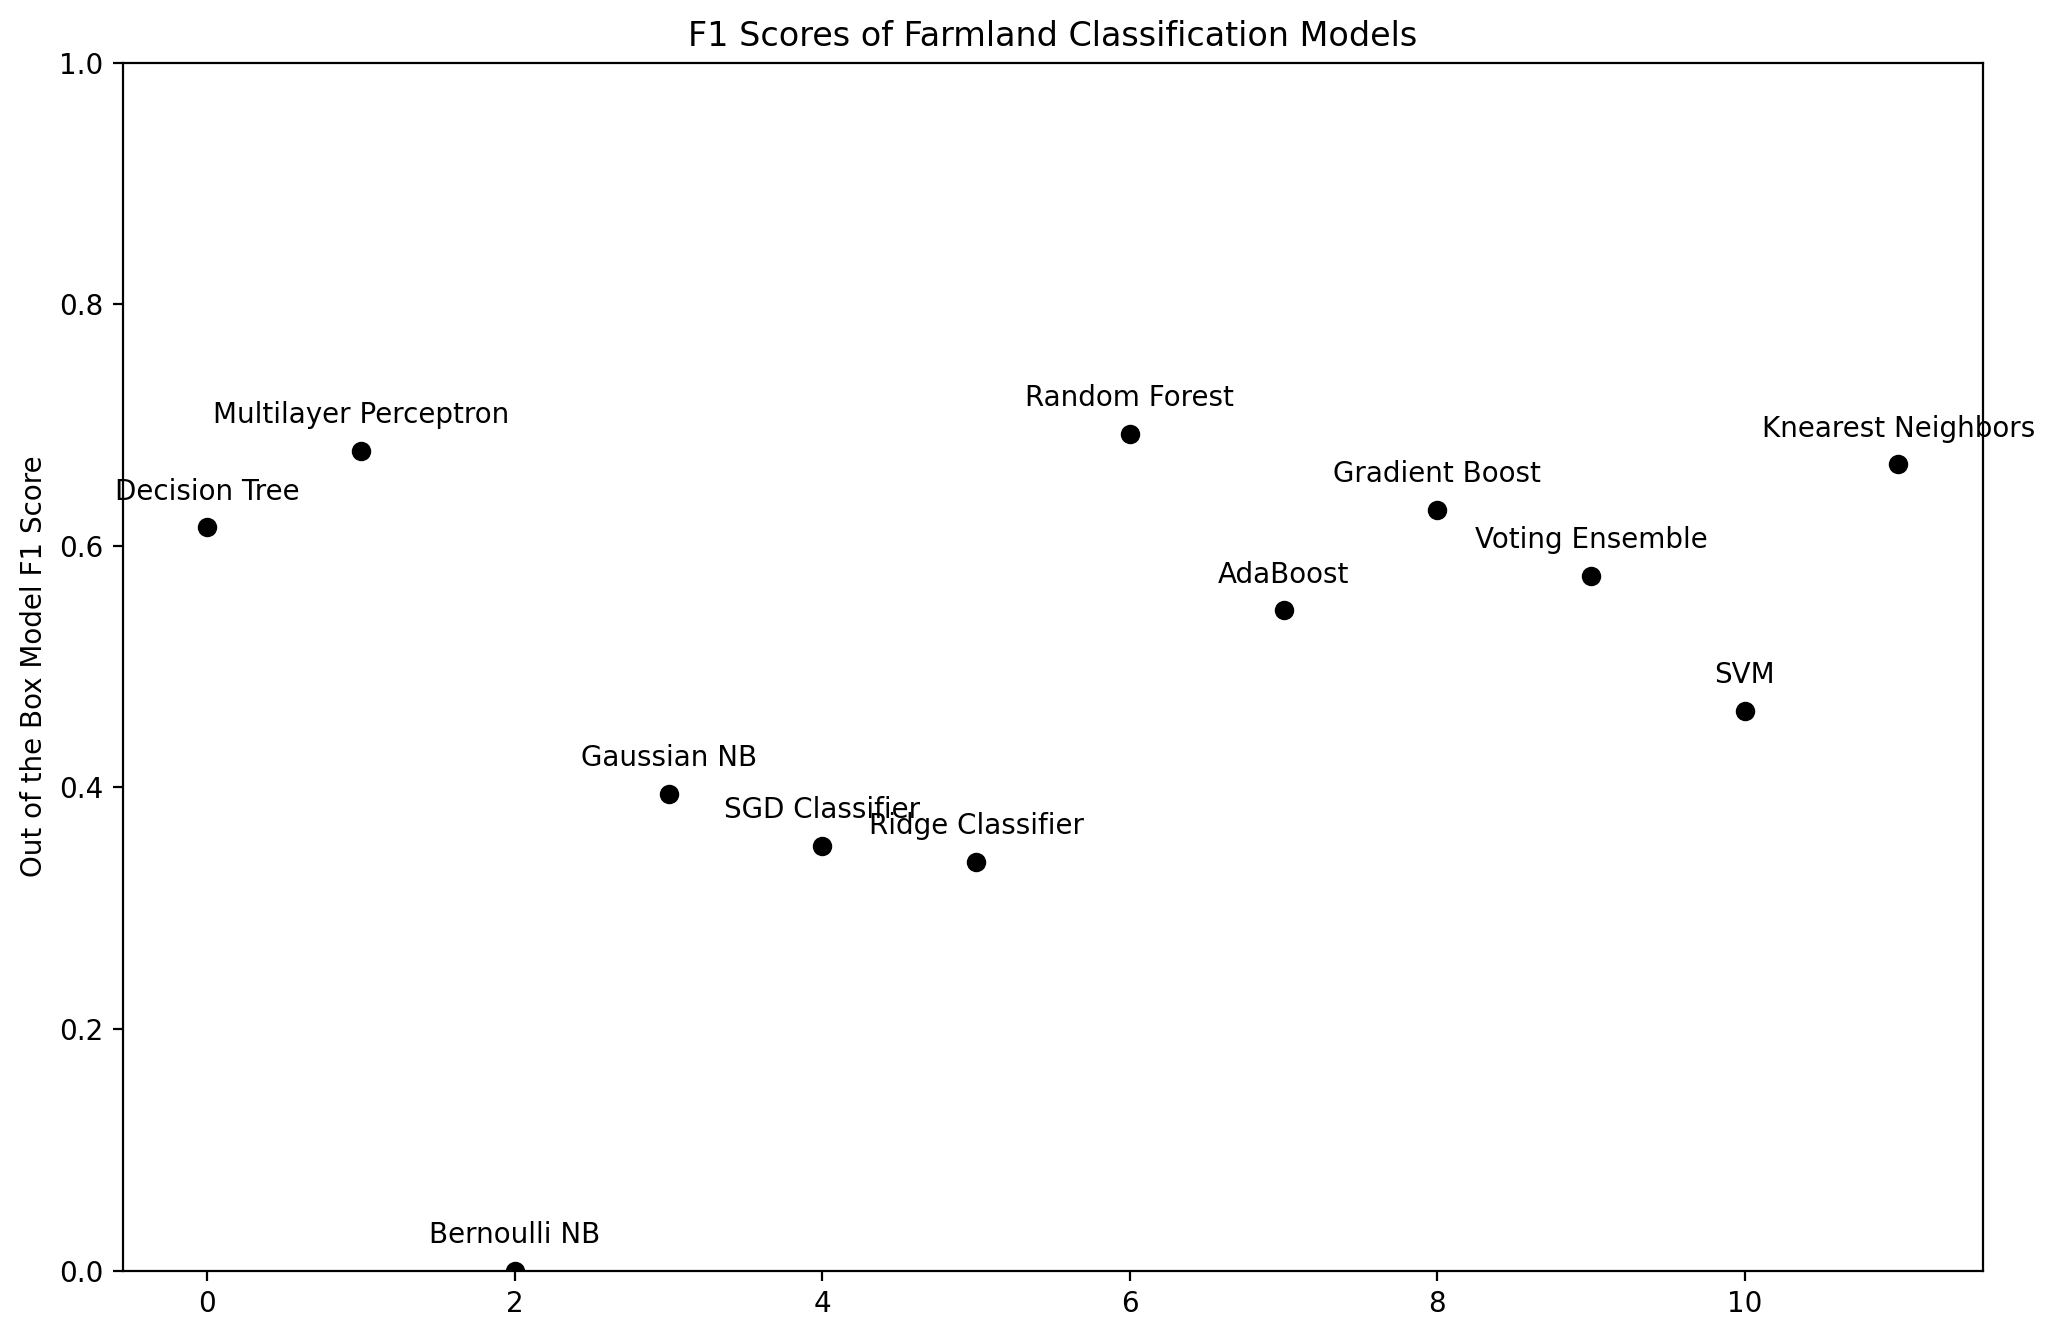

In [108]:
plt.plot(modelf1, 'ko')
plt.ylabel('Out of the Box Model F1 Score')
plt.title('F1 Scores of Farmland Classification Models')
plt.ylim(0,1)

for idx, label in enumerate(modellabels):
    plt.annotate(label, # this is the text
                 (idx,modelf1[idx]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.show()

Perform hyperparameter tuning of random forest model

In [269]:
# import randomized search cross validation
from sklearn.model_selection import RandomizedSearchCV

In [270]:
# calculate train and test lengths
train_numsamp = image_train.shape[0]
# generate limited dataset to perform hyperparameter tuning
image_train_lim = image_train[::200,:]
label_train_lim = label_train[::200]

In [271]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [272]:
# create base model to tune hyperparameters
rf = RandomForestClassifier()
# search 100 different combinations of hyperparemeters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 3, verbose = 2, random_state=5)
# fit the random search model
rf_random.fit(image_train_lim, label_train_lim)
# print best parameters
rf_random.best_score_
rf_random.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   9.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   9.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   9.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   5.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   5.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=   5.8s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [273]:
# predict values using best estimator
tuned_model = rf_random.best_estimator_
tuned_predicted = tuned_model.predict(image_test)
# calculated tuned accuracy and f1
tuned_accuracy = accuracy_score(label_test,tuned_predicted)
tuned_f1 = f1_score(label_test,tuned_predicted)
# print optimal accuracy and f1
print('tuned accuracy:',tuned_accuracy)
print('tuned f1:',tuned_f1)

tuned accuracy: 0.4709683333333333
tuned f1: 0.3612143044011994


Perform more constrained random search

In [274]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto','log2']
# Maximum number of levels in tree
max_depth = []
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,4,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# selecting samples to train each tree
max_samples = [int(x) for x in np.linspace(start = 1000, stop = 20000, num = 20)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'max_samples': max_samples}

In [275]:
# create base model to tune hyperparameters
rfdeep = RandomForestClassifier()
# search 100 different combinations of hyperparemeters
rf_grid = RandomizedSearchCV(estimator = rfdeep, param_distributions = random_grid, n_iter=40, cv = 4, verbose=2, random_state=5)
# fit the random search model
rf_grid.fit(image_train_lim, label_train_lim)
# print best parameters
print(rf_grid.best_params_)
print(rf_grid.best_score_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_samples=19000, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_samples=19000, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_samples=19000, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_samples=19000, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s


/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 18000 but got value 19000

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning

[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=11000, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=11000, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=11000, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=11000, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=13000, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=13000, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=lo

/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 104, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samples))
ValueError: `max_samples` must be in range 1 to 18000 but got value 19000

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning

[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=13000, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=13000, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=13000, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=log2, max_samples=13000, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_samples=15000, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, max_samples=15000, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   8.4s
[CV] END bootstrap=True, max_depth=None, max_features=

/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.88191667 0.88220833 0.88429167 0.88079167 0.8815
 0.882375   0.88204167 0.878625          nan 0.88129167 0.88054167
 0.87766667 0.88254167 0.882125   0.88329167 0.88091667 0.88220833
 0.882125   0.88145833 0.88120833 0.88245833 0.88004167 0.88195833
 0.88266667 0.88079167 0.882      0.8835     0.87908333 0.882875
 0.8825     0.88283333 0.8815     0.881625   0.88266667 0.8825
 0.88170833 0.88191667 0.88029167 0.88004167]
  warnings.warn(


{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 5000, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
0.8842916666666667


In [ ]:
# predict values using best estimator
gridtuned_model = rf_random.best_estimator_.fit(image_train,label_train)
gridtuned_predicted = gridtuned_model.predict(image_test)
# calculated tuned accuracy and f1
gridtuned_accuracy = accuracy_score(label_test,gridtuned_predicted)
gridtuned_f1 = f1_score(label_test,gridtuned_predicted)
# print optimal accuracy and f1
print('tuned accuracy:',gridtuned_accuracy)
print('tuned f1:',gridtuned_f1)

Train on full data for tuned parameters

In [263]:
# generate new model with tuned hyperparameters
gridtuned_bag = RandomForestClassifier(n_estimators = 500, min_samples_split = 4, min_samples_leaf = 1, max_features = 'auto', max_depth = None, bootstrap = True) # , max_samples=5000)
# train model on full data
gridtuned_bag.fit(image_train, label_train)

RandomForestClassifier(min_samples_split=4, n_estimators=500)

In [259]:
# generate new model with tuned hyperparameters
gridtuned_full = BaggingClassifier(n_estimators = 500, bootstrap = True, bootstrap_features = True)
# train model on full data
gridtuned_full.fit(image_train[:60000,:], label_train[:60000])

BaggingClassifier(bootstrap_features=True, n_estimators=500)

In [264]:
# test on validation data
gridtunedfull_predicted = gridtuned_full.predict(image_test)
# calculated tuned accuracy and f1
gridtunedfull_accuracy = accuracy_score(label_test,gridtunedfull_predicted)
gridtunedfull_f1 = f1_score(label_test,gridtunedfull_predicted)
# print optimal accuracy and f1
print('tuned accuracy:',gridtunedfull_accuracy)
print('tuned f1:',gridtunedfull_f1)

tuned accuracy: 0.47476833333333335
tuned f1: 0.3562456463609195


In [264]:
# test on validation data
gridtunedbag_predicted = gridtuned_bag.predict(image_test)
# calculated tuned accuracy and f1
gridtunedbag_accuracy = accuracy_score(label_test,gridtunedbag_predicted)
gridtunedbag_f1 = f1_score(label_test,gridtunedbag_predicted)
# print optimal accuracy and f1
print('tuned bag accuracy:\t',gridtunedbag_accuracy)
print('tuned bag f1:\t\t',gridtunedbag_f1)

tuned accuracy: 0.47476833333333335
tuned f1: 0.3562456463609195
